|Họ Tên                                 | MSSV              |Tỷ lệ đóng góp  |
|:--------------------------------------|:------------------|:---------------|
|Đặng Thị Kim Anh                       |21280084           |30%             |
|Lê Hồ Hoàng Anh                        |21280085           |40%             |
|Nguyễn Phúc Loan                       |21280098           |30%             |

# Web scraping

#### Thêm các thư viện cần thiết vào để scrape data

In [ ]:
from bs4 import BeautifulSoup
import urllib.request
import requests
import pandas as pd
import numpy as np
import re

#### Sử dụng BeautifulSoup, Regex để xử lý, tách các dữ liệu cần thiết từ trang web

In [ ]:
def download_html(url):
  with urllib.request.urlopen(url) as response:
    html = response.read()
    html = html.decode('utf-8')
  response.close()
  return html

In [ ]:
url = "https://batdongsan.vn/ban-nha/"
html = download_html(url)
soup = BeautifulSoup(html, 'lxml')

#### Hàm phía dưới dùng để tìm được số phòng ngủ, số phòng WC mà mỗi căn nhà có được, nếu không có giá trị sẽ mặc định là NaN value

In [ ]:
def scrape_room(soup_link):
  text1=soup_link.find('div',class_='body').text.replace('\n','').replace('\t','').strip()
  text3=soup_link.find('div',class_='content').text.replace('\n','').replace('\r','').strip()
  try:
    so_PN=(re.search(r"(\d+)\s*PN", text1).group(1))
  except:
    try:
      so_PN=(re.search(r"(\d+)PN", text1).group(1))
    except:
      try:
        so_PN=(re.search(r"(\d+)\s*PN", text3).group(1))
      except:
        try:
          so_PN=(re.search(r"(\d+)PN", text3).group(1))
        except:
          so_PN=(np.nan)
  try:
    so_WC=(re.search(r"(\d+)\s*WC", text1).group(1))
  except:
    try:
      so_WC=(re.search(r"(\d+)WC", text1).group(1))
    except:
      try:
        so_WC=(re.search(r"(\d+)\s*WC", text3).group(1))
      except:
        try:
          so_WC=(re.search(r"(\d+)WC", text3).group(1))
        except:
          so_WC=(np.nan)
  return so_PN, so_WC

In [ ]:
link = soup.find_all('div', {"class":"name"})
link_pos = link[4].find('a').get('href')
html_link = download_html(link_pos)
soup_link = BeautifulSoup(html_link, 'lxml')
scrape_room(soup_link)[0]

#### Hàm phía dưới dùng để scrape 1 tin được đăng lên web

In [ ]:
def scrape_block(house_block, pos):
  houseb_data = {}
  link = soup.find_all('div', {"class":"name"})
  link_pos = link[pos].find('a').get('href')
  html_link = download_html(link_pos)
  soup_link = BeautifulSoup(html_link, 'lxml')

  text1 = soup_link.find('div',{'class':'body'}).text.replace('\n','').replace('\t','').strip()
  text3 = soup_link.find('div',{'class':'content'}).text.replace('\n','').replace('\r','').strip()

  try:
    houseb_data['ID'] = int(soup_link.find_all('ul',{'class':"uk-list"})[6].find('span').contents[1].strip())
  except:
    houseb_data['ID'] = np.nan

  try:
    houseb_data['acreage'] = int(soup.find_all('span', {'class':"acreage"})[pos].contents[0].strip().replace("m",""))
  except:
    houseb_data['acreage'] = np.nan

  houseb_data['so_PN'] = scrape_room(soup_link)[0]

  houseb_data['so_WC'] = scrape_room(soup_link)[1]

  try:
    houseb_data['price'] = soup.find_all('span', {'class':"price"})[pos].contents[0].strip()
  except:
    houseb_data['price'] = np.nan

  try:
    text = soup_link.find('div', {"class":"content"}).get_text().strip()
    if "mặt tiền" in text:
      houseb_data['frontage'] = 1
    else:
      houseb_data['frontage'] = 0
  except:
    houseb_data['frontage'] = np.nan

  try:
    houseb_data['area'] = str(soup_link.find('ul',{'class':"uk-breadcrumb"}).find_all('a')[3].contents[0].strip())
  except:
    houseb_data['area'] = np.nan

  try:
    houseb_data['city'] = str(soup_link.find('ul',{'class':"uk-breadcrumb"}).find_all('a')[2].contents[0].strip())
  except:
    houseb_data['city'] = np.nan

  return houseb_data

#### Hàm scrape_house_page dùng để cào tất cả các tin ở trên 1 trang

In [ ]:
def scrape_house_page(house_blocks):

  page_house_data = []
  num_blocks = len(house_blocks)

  for block in range(num_blocks - 5):
      page_house_data.append(scrape_block(house_blocks[block], block))

  return page_house_data

#### Chạy vòng lặp for để thu thập tất cả thông tin ở các trang kế tiếp
#### Vì một số trang không thể thu thập nên ta chạy trong khoảng 1 đến 900 cách nhau 4 trang

In [ ]:
house_data = []
for i in range(1, 900, 4):
    base_url ="https://batdongsan.vn/ban-nha/"
    source = download_html(base_url + 'p' + str(i))
    soup = BeautifulSoup(source, 'html.parser')
    house_blocks = soup.find_all('div', {'class':"body"})
    house_data.extend(scrape_house_page(house_blocks))
house_data = pd.DataFrame(house_data)
house_data

In [ ]:
house_data.to_csv("house_data.csv")
house_data

,Unnamed: 0,ID,acreage,so_PN,so_WC,price,frontage,area,city
0,0,269453.0,37.0,NaN,NaN,Thỏa thuận,1,Bắc Từ Liêm,Hà Nội
1,1,269452.0,20.0,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
2,2,269451.0,NaN,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
3,3,269450.0,NaN,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
4,4,269449.0,NaN,NaN,NaN,Thỏa thuận,0,Nam Từ Liêm,Hà Nội
...,...,...,...,...,...,...,...,...,...
2529,2529,250238.0,54.0,5.0,3.0,4.95 tỷ,0,Hoàng Mai,Hà Nội
2530,2530,250237.0,50.0,NaN,NaN,7.5 tỷ,0,Đống Đa,Hà Nội
2531,2531,250235.0,100.0,NaN,NaN,6 tỷ,0,Thủ Đức,TP Hồ Chí Minh
2532,2532,249841.0,52.0,3.0,2.0,3.48 tỷ,0,Quận 12,TP Hồ Chí Minh


#### Phía trên là data thu được

### Xử lý missing data bằng phương pháp MICE

#### Thêm vào các thư viện cần thiết

In [ ]:
import pandas as pd
import numpy as np
from fancyimpute import IterativeImputer
import seaborn as sns

#### Đọc lại data từ file csv đã được lưu sau khi thu thập từ trang web

In [ ]:
house_data = pd.read_csv('house_data.csv')

house_data

#### Loại bỏ cột 'Unnamed: 0' vì không cần thiết

In [ ]:
house_data = house_data.drop(columns='Unnamed: 0')

In [ ]:
house_data

,ID,acreage,so_PN,so_WC,price,frontage,area,city
0,269453.0,37.0,NaN,NaN,Thỏa thuận,1,Bắc Từ Liêm,Hà Nội
1,269452.0,20.0,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
2,269451.0,NaN,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
3,269450.0,NaN,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
4,269449.0,NaN,NaN,NaN,Thỏa thuận,0,Nam Từ Liêm,Hà Nội
...,...,...,...,...,...,...,...,...
2529,250238.0,54.0,5.0,3.0,4.95 tỷ,0,Hoàng Mai,Hà Nội
2530,250237.0,50.0,NaN,NaN,7.5 tỷ,0,Đống Đa,Hà Nội
2531,250235.0,100.0,NaN,NaN,6 tỷ,0,Thủ Đức,TP Hồ Chí Minh
2532,249841.0,52.0,3.0,2.0,3.48 tỷ,0,Quận 12,TP Hồ Chí Minh


#### Kiểm tra tần số bán nhà để xem các quận huyện nào có lượng nhà cần bán nhiều nhất

In [ ]:
freq = house_data.groupby('area')['area'].agg('count').sort_values(ascending = False)
print(freq.to_string())

area
Gò Vấp                   203
Bình Tân                 168
Bình Thạnh               162
Tân Bình                 162
Thủ Đức                  121
Quận 7                   107
Tân Phú                  105
Hoàng Mai                 82
Biên Hòa                  80
Đống Đa                   76
Hai Bà Trưng              70
Cầu Giấy                  69
Thanh Xuân                67
Phú Nhuận                 64
Quận 10                   62
Hà Đông                   61
Quận 12                   51
Quận 9                    50
Long Biên                 49
Quận 8                    49
Tây Hồ                    41
Thanh Trì                 36
Hải Châu                  34
Huế                       33
Tân Uyên                  33
Thanh Khê                 32
Quận 3                    32
Hồng Bàng                 25
Ba Đình                   24
Nha Trang                 20
Hóc Môn                   19
Nam Từ Liêm               19
Quận 1                    17
Quận 4                    16
Quận 11  

#### kiểm tra tần số bán nhà để xem các tỉnh thành nào có lượng nhà cần bán nhiều nhất

In [ ]:
fre = house_data.groupby('city')['city'].agg('count').sort_values(ascending = False)
print(fre.to_string())

city
TP Hồ Chí Minh     1438
Hà Nội              634
Đà Nẵng             114
Đồng Nai             94
Bình Dương           51
Hải Phòng            44
Thừa Thiên Huế       41
Khánh Hòa            21
Hậu Giang            15
Long An              13
Lâm Đồng             12
Tiền Giang           10
Bắc Ninh             10
Cần Thơ               5
An Giang              3
Kiên Giang            3
Bình Thuận            3
Bà Rịa Vũng Tàu       2
Ninh Thuận            2
Bến Tre               2
Yên Bái               2
Bình Phước            2
Lào Cai               2
Nam Định              1
Ninh Bình             1
Quảng Nam             1
Sóc Trăng             1
Cà Mau                1
Thanh Hóa             1
Đắk Lắk               1


In [ ]:
house_data['price']

0       Thỏa thuận
1       Thỏa thuận
2       Thỏa thuận
3       Thỏa thuận
4       Thỏa thuận
           ...    
2529       4.95 tỷ
2530        7.5 tỷ
2531          6 tỷ
2532       3.48 tỷ
2533        1.1 tỷ
Name: price, Length: 2534, dtype: object

#### Nhận thấy ở cột price, các giá trị gồm nhiều thành phần như 'Thỏa thuận', 'tỷ', 'triệu', 'nghìn' nên ta xử lý để thành đơn vị 'tỷ'
#### Xem các giá trị 'Thỏa thuận' là các giá trị NaN

In [ ]:
def convert_price(price):
    if 'Thỏa thuận' in price:
        price = np.nan
    elif 'nghìn' in price:
        price = float(price.replace('nghìn', ''))/1000
    elif 'triệu' in price:
        price = float(price.replace('triệu', ''))/1000000
    else:
        price = float(price.replace('tỷ', ''))
    return price

In [ ]:
house_data.price = house_data.price.apply(lambda x: convert_price(x))

In [ ]:
house_data

,ID,acreage,so_PN,so_WC,price,frontage,area,city
0,269453.0,37.0,NaN,NaN,NaN,1,Bắc Từ Liêm,Hà Nội
1,269452.0,20.0,NaN,NaN,NaN,0,Bắc Từ Liêm,Hà Nội
2,269451.0,NaN,NaN,NaN,NaN,0,Bắc Từ Liêm,Hà Nội
3,269450.0,NaN,NaN,NaN,NaN,0,Bắc Từ Liêm,Hà Nội
4,269449.0,NaN,NaN,NaN,NaN,0,Nam Từ Liêm,Hà Nội
...,...,...,...,...,...,...,...,...
2529,250238.0,54.0,5.0,3.0,4.95,0,Hoàng Mai,Hà Nội
2530,250237.0,50.0,NaN,NaN,7.50,0,Đống Đa,Hà Nội
2531,250235.0,100.0,NaN,NaN,6.00,0,Thủ Đức,TP Hồ Chí Minh
2532,249841.0,52.0,3.0,2.0,3.48,0,Quận 12,TP Hồ Chí Minh


#### Kiểm tra house_data

<Axes: >

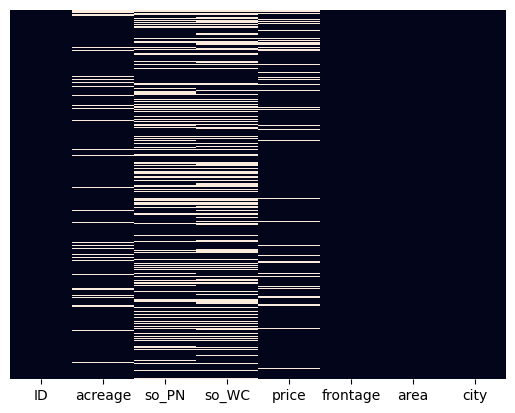

In [ ]:
sns.heatmap(house_data.isnull(),yticklabels = False,cbar = False)

In [ ]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        2530 non-null   float64
 1   acreage   2288 non-null   float64
 2   so_PN     1769 non-null   float64
 3   so_WC     1617 non-null   float64
 4   price     2278 non-null   float64
 5   frontage  2534 non-null   int64  
 6   area      2530 non-null   object 
 7   city      2530 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 158.5+ KB


#### Theo quan sát, các feature như 'ID', 'frontage', 'area' 'city' không nhận giá trị NaN hoặc NULL tại tất cả nên ta chỉ xét trên các cột còn lại

In [ ]:
house_data_train = house_data.loc[:, ['acreage', 'so_PN', 'so_WC', 'price']]
house_data_train

,acreage,so_PN,so_WC,price
0,37.0,NaN,NaN,NaN
1,20.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
2529,54.0,5.0,3.0,4.95
2530,50.0,NaN,NaN,7.50
2531,100.0,NaN,NaN,6.00
2532,52.0,3.0,2.0,3.48


#### Sử dụng thư viện IterativeImputer để xử lý missing data

In [ ]:
mice_imputer = IterativeImputer(random_state=100, max_iter = 10)
mice_imputer.fit(house_data_train)

IterativeImputer(random_state=100)

In [ ]:
house_data_imputer = mice_imputer.transform(house_data_train)
house_data_imputer

array([[3.70000000e+01, 3.58285273e+00, 3.54162609e+00, 1.49414778e+08],
       [2.00000000e+01, 3.52142864e+00, 3.50260645e+00, 1.49414778e+08],
       [7.70041626e+01, 3.72739504e+00, 3.63344656e+00, 1.49414778e+08],
       ...,
       [1.00000000e+02, 3.81036887e+00, 3.68657166e+00, 6.00000000e+00],
       [5.20000000e+01, 3.00000000e+00, 2.00000000e+00, 3.48000000e+00],
       [6.00000000e+01, 1.00000000e+00, 1.00000000e+00, 1.10000000e+00]])

In [ ]:
house_data.loc[:, ['acreage', 'so_PN', 'so_WC', 'price']] = house_data_imputer

#### Data thu được sau khi xử lý MICE

In [ ]:
house_data

,ID,acreage,so_PN,so_WC,price,frontage,area,city
0,269453.0,37.000000,3.582853,3.541626,1.494148e+08,1,Bắc Từ Liêm,Hà Nội
1,269452.0,20.000000,3.521429,3.502606,1.494148e+08,0,Bắc Từ Liêm,Hà Nội
2,269451.0,77.004163,3.727395,3.633447,1.494148e+08,0,Bắc Từ Liêm,Hà Nội
3,269450.0,77.004163,3.727395,3.633447,1.494148e+08,0,Bắc Từ Liêm,Hà Nội
4,269449.0,77.004163,3.727395,3.633447,1.494148e+08,0,Nam Từ Liêm,Hà Nội
...,...,...,...,...,...,...,...,...
2529,250238.0,54.000000,5.000000,3.000000,4.950000e+00,0,Hoàng Mai,Hà Nội
2530,250237.0,50.000000,3.629710,3.571808,7.500000e+00,0,Đống Đa,Hà Nội
2531,250235.0,100.000000,3.810369,3.686572,6.000000e+00,0,Thủ Đức,TP Hồ Chí Minh
2532,249841.0,52.000000,3.000000,2.000000,3.480000e+00,0,Quận 12,TP Hồ Chí Minh


<Axes: >

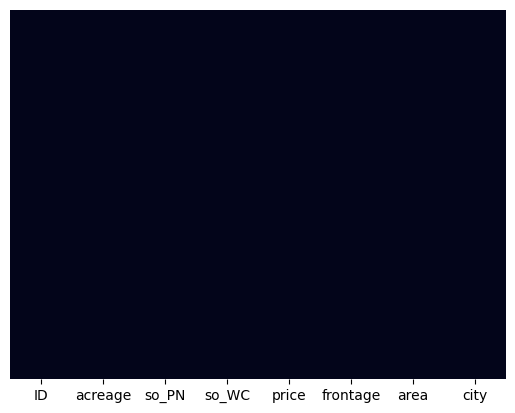

In [ ]:
sns.heatmap(house_data.isnull(),yticklabels = False,cbar = False)

In [ ]:
house_data.to_csv('house_final.csv')

In [ ]:
df=pd.read_csv("house_final2.csv")

In [ ]:
df=df.drop(columns=['ID'])

In [ ]:
df

,acreage,so_PN,so_WC,price,frontage,area,city
0,37.000000,3.582853,3.541626,1.494148e+08,1,Bắc Từ Liêm,Hà Nội
1,20.000000,3.521429,3.502606,1.494148e+08,0,Bắc Từ Liêm,Hà Nội
2,77.004163,3.727395,3.633447,1.494148e+08,0,Bắc Từ Liêm,Hà Nội
3,77.004163,3.727395,3.633447,1.494148e+08,0,Bắc Từ Liêm,Hà Nội
4,77.004163,3.727395,3.633447,1.494148e+08,0,Nam Từ Liêm,Hà Nội
...,...,...,...,...,...,...,...
2529,54.000000,5.000000,3.000000,4.950000e+00,0,Hoàng Mai,Hà Nội
2530,50.000000,3.629710,3.571808,7.500000e+00,0,Đống Đa,Hà Nội
2531,100.000000,3.810369,3.686572,6.000000e+00,0,Thủ Đức,TP Hồ Chí Minh
2532,52.000000,3.000000,2.000000,3.480000e+00,0,Quận 12,TP Hồ Chí Minh


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("house_final.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1160 non-null   int64  
 1   ID          1160 non-null   int64  
 2   acreage     1160 non-null   float64
 3   so_PN       1160 non-null   float64
 4   so_WC       1160 non-null   float64
 5   price       1160 non-null   float64
 6   frontage    1160 non-null   int64  
 7   area        1160 non-null   object 
 8   city        1160 non-null   object 
dtypes: float64(4), int64(3), object(2)
memory usage: 81.7+ KB


In [ ]:
# Gán lại giá trị int cho các dữ liệu object

le = LabelEncoder()
is_Category = df.dtypes == object
category_column_list = df.columns[is_Category].tolist()
df[category_column_list] = df[category_column_list].apply(lambda col: le.fit_transform(col))

# Training Models

## Chia dữ liệu thành các tập train, test

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

X = df.drop(columns='price')
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)


## Chuẩn hóa dữ liệu

In [ ]:
from sklearn.preprocessing import  StandardScaler

sc=StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Kiểm tra và xử lý giá trị NaN
nan_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = nan_imputer.fit_transform(X)

# Kiểm tra và xử lý giá trị vô cùng
X = np.nan_to_num(X, nan=0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
### Dự đoán bằng cách áp model Linear Regression
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

#### MSE

In [ ]:
lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
print('LR MSE (Train): ', lr_train_mse)
print('LR MSE (Test): ', lr_test_mse)

LR MSE (Train):  1.7797093075450604e+18
LR MSE (Test):  9.422914326976543e+17


#### RMSE

In [ ]:
#rms = sqrt(mean_squared_error(y_actual, y_predicted))
lr_train_rmse = sqrt(mean_squared_error(y_train, y_lr_train_pred))
lr_test_rmse = sqrt(mean_squared_error(y_test, y_lr_test_pred))
print('LR RMSE (Train): ', lr_train_rmse)
print('LR RMSE (Test): ', lr_test_rmse)

LR RMSE (Train):  1334057460.361082
LR RMSE (Test):  970716968.3783499


#### MAE

In [ ]:
lr_train_mae = mean_absolute_error(y_train, y_lr_train_pred)
lr_test_mae = mean_absolute_error(y_test, y_lr_test_pred)
print('LR MAE (Train): ', lr_train_mae)
print('LR MAE (Test): ', lr_test_mae)

LR MAE (Train):  358821573.1191792
LR MAE (Test):  361225573.4932723


#### R2S

In [ ]:
lr_train_r2s = r2_score(y_train, y_lr_train_pred)
lr_test_r2s = r2_score(y_test, y_lr_test_pred)
print('LR R2S (Train): ', lr_train_r2s)
print('LR R2S (Test): ', lr_test_r2s)

LR R2S (Train):  0.045061818317309155
LR R2S (Test):  -0.07151238569784346


## Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
rr = Ridge()
rr.fit(X_train, y_train)

Ridge()

In [ ]:
### Dự đoán bằng cách áp model Ridge Regression
y_rr_train_pred = rr.predict(X_train)
y_rr_test_pred = rr.predict(X_test)

#### MSE

In [ ]:
rr_train_mse = mean_squared_error(y_train, y_rr_train_pred)
rr_test_mse = mean_squared_error(y_test, y_rr_test_pred)
print('RR MSE (Train): ', rr_train_mse)
print('RR MSE (Test): ', rr_test_mse)

RR MSE (Train):  1.780186302454173e+18
RR MSE (Test):  9.378860960459638e+17


#### RMSE

In [ ]:
rr_train_rmse = sqrt(mean_squared_error(y_train, y_rr_train_pred))
rr_test_rmse = sqrt(mean_squared_error(y_test, y_rr_test_pred))
print('RR RMSE (Train): ', rr_train_rmse)
print('RR RMSE (Test): ', rr_test_rmse)

RR RMSE (Train):  1334236224.382389
RR RMSE (Test):  968445195.1690214


#### MAE

In [ ]:
rr_train_mae = mean_absolute_error(y_train, y_rr_train_pred)
rr_test_mae = mean_absolute_error(y_test, y_rr_test_pred)
print('RR MAE (Train): ', rr_train_mae)
print('RR MAE (Test): ', rr_test_mae)

RR MAE (Train):  355418953.3822769
RR MAE (Test):  356624552.0959633


#### R2S

In [ ]:
rr_train_r2s = r2_score(y_train, y_rr_train_pred)
rr_test_r2s = r2_score(y_test, y_rr_test_pred)
print('RR R2S (Train): ', rr_train_r2s)
print('RR R2S (Test): ', rr_test_r2s)

RR R2S (Train):  0.04480587727724794
RR R2S (Test):  -0.06650292405820912


## Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

ls = Lasso(alpha=1.0)
ls.fit(X_train, y_train)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.258e+20, tolerance: 1.730e+17
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [ ]:
### Dự đoán bằng cách áp model Lasso Regression
y_ls_train_pred = ls.predict(X_train)
y_ls_test_pred = ls.predict(X_test)

#### MSE

In [ ]:
ls_train_mse = mean_squared_error(y_train, y_ls_train_pred)
ls_test_mse = mean_squared_error(y_test, y_ls_test_pred)
print('LS MSE (Train): ', ls_train_mse)
print('LS MSE (Test): ', ls_test_mse)

LS MSE (Train):  1.7797106193388726e+18
LS MSE (Test):  9.420627695498789e+17


#### RMSE

In [ ]:
ls_train_rmse = sqrt(mean_squared_error(y_train, y_ls_train_pred))
ls_test_rmse = sqrt(mean_squared_error(y_test, y_ls_test_pred))
print('LS RMSE (Train): ', ls_train_rmse)
print('LS RMSE (Test): ', ls_test_rmse)

LS RMSE (Train):  1334057952.0166552
LS RMSE (Test):  970599180.6867956


#### MAE

In [ ]:
ls_train_mae = mean_absolute_error(y_train, y_ls_train_pred)
ls_test_mae = mean_absolute_error(y_test, y_ls_test_pred)
print('LS MAE (Train): ', ls_train_mae)
print('LS MAE (Test): ', ls_test_mae)

LS MAE (Train):  358625746.06477857
LS MAE (Test):  361001308.1457367


#### R2S

In [ ]:
ls_train_r2s = r2_score(y_train, y_ls_train_pred)
ls_test_r2s = r2_score(y_test, y_ls_test_pred)
print('LS R2S (Train): ', ls_train_r2s)
print('LS R2S (Test): ', ls_test_r2s)

LS R2S (Train):  0.04506111444842875
LS R2S (Test):  -0.07125236487361453


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, max_depth=5, bootstrap=True, random_state=2023, verbose=False, n_jobs=12).fit(X_train, y_train)

In [ ]:
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

#### MSE

In [ ]:
rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
print('RF MSE (Train): ', rf_train_mse)
print('RF MSE (Test): ', rf_test_mse)

RF MSE (Train):  3.5389126826570054e+17
RF MSE (Test):  6.50964247953049e+17


#### RMSE

In [ ]:
rf_train_rmse = sqrt(mean_squared_error(y_train, y_rf_train_pred))
rf_test_rmse = sqrt(mean_squared_error(y_test, y_rf_test_pred))
print('RF RMSE (Train): ', rf_train_rmse)
print('RF RMSE (Test): ', rf_test_rmse)

RF RMSE (Train):  594887609.7765868
RF RMSE (Test):  806823554.4114022


#### MAE

In [ ]:
rf_train_mae = mean_absolute_error(y_train, y_rf_train_pred)
rf_test_mae = mean_absolute_error(y_test, y_rf_test_pred)
print('RF MAE (Train): ', rf_train_mae)
print('RF MAE (Test): ', rf_test_mae)

RF MAE (Train):  139571432.48448148
RF MAE (Test):  241020774.0123479


#### R2S

In [ ]:
rf_train_r2s = r2_score(y_train, y_rf_train_pred)
rf_test_r2s = r2_score(y_test, y_rf_test_pred)
print('RF R2S (Train): ', rf_train_r2s)
print('RF R2S (Test): ', rf_test_r2s)

RF R2S (Train):  0.8101126499713645
RF R2S (Test):  0.259765896065426


## Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [ ]:
y_gb_train_pred = rf.predict(X_train)
y_gb_test_pred = rf.predict(X_test)

#### MSE

In [ ]:
gb_train_mse = mean_squared_error(y_train, y_gb_train_pred)
gb_test_mse = mean_squared_error(y_test, y_gb_test_pred)
print('GB MSE (Train): ', gb_train_mse)
print('GB MSE (Test): ', gb_test_mse)

GB MSE (Train):  3.5389126826570054e+17
GB MSE (Test):  6.50964247953049e+17


#### RMSE

In [ ]:
gb_train_rmse = sqrt(mean_squared_error(y_train, y_gb_train_pred))
gb_test_rmse = sqrt(mean_squared_error(y_test, y_gb_test_pred))
print('GB RMSE (Train): ', gb_train_rmse)
print('GB RMSE (Test): ', gb_test_rmse)

GB RMSE (Train):  594887609.7765868
GB RMSE (Test):  806823554.4114022


#### MAE

In [ ]:
gb_train_mae = mean_absolute_error(y_train, y_gb_train_pred)
gb_test_mae = mean_absolute_error(y_test, y_gb_test_pred)
print('GB MAE (Train): ', gb_train_mae)
print('GB MAE (Test): ', gb_test_mae)

GB MAE (Train):  139571432.48448148
GB MAE (Test):  241020774.0123479


#### R2S

In [ ]:
gb_train_r2s = r2_score(y_train, y_gb_train_pred)
gb_test_r2s = r2_score(y_test, y_gb_test_pred)
print('GB R2S (Train): ', gb_train_r2s)
print('GB R2S (Test): ', gb_test_r2s)

GB R2S (Train):  0.8101126499713645
GB R2S (Test):  0.259765896065426


In [ ]:
print("LinearRegression")

print(">> Train R2-score: ", lr_train_r2s)
print(">> Test R2-score: ", lr_test_r2s)

print("RidgeRegression")

print(">> Train R2-score: ", rr_train_r2s)
print(">> Test R2-score: ", rr_test_r2s)

print("LassoRegression")

print(">> Train R2-score: ", ls_train_r2s)
print(">> Test R2-score: ", ls_test_r2s)

print("RandomForest")

print(">> Train R2-score: ", rf_train_r2s)
print(">> Test R2-score: ", rf_test_r2s)

print("GradientBoost")

print(">> Train R2-score: ", gb_train_r2s)
print(">> Test R2-score: ", gb_test_r2s)


LinearRegression
>> Train R2-score:  0.045061818317309155
>> Test R2-score:  -0.07151238569784346
RidgeRegression
>> Train R2-score:  0.04480587727724794
>> Test R2-score:  -0.06650292405820912
LassoRegression
>> Train R2-score:  0.04506111444842875
>> Test R2-score:  -0.07125236487361453
RandomForest
>> Train R2-score:  0.8101126499713645
>> Test R2-score:  0.259765896065426
GradientBoost
>> Train R2-score:  0.8101126499713645
>> Test R2-score:  0.259765896065426


##### Nhóm em chọn đánh giá hiệu quả của các mô hình dựa trên R2-score (hệ số xác định R2) vì R2-score đo lường mức độ phù hợp giữa dữ liệu thực tế và dự đoán của mô hình. Giá trị R2-score nằm trong khoảng từ 0 đến 1, với giá trị 1 cho thấy mô hình hoàn toàn phù hợp với dữ liệu thực tế. Trong 5 models trên, cả Random Forest và Gradient Boost đều có hệ số R2-score ngang nhau. Tuy nhiên, em thiên về Gradient Boost hơn vì đây là model có khả năng thích nghi và học hỏi sai lầm tốt hơn.